In [1]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import inspect
import orbithunter.ks as ks
import h5py
import time
import orbithunter.persistent_homology as ohgudhi
from orbithunter.persistent_homology import gudhi_distance_from_persistence, orbit_persistence
from orbithunter.shadowing import scanning_dimensions
import matplotlib.pyplot as plt 
from matplotlib import gridspec

# Filling algorithm

Different from covering algorithm, technically more correct at the moment; instead of checking every point individually for each orbit it finds the orbit which minimizes the cost function at each point; i.e. orbit vs. orbit comparison.  

The following are some assorted cost functions tested for the purpose of filling.

In [9]:
def masked_l2_difference_density(base_slice, window, *args, **kwargs):
    base_mask = base_slice.copy().astype(bool)
    norm = np.linalg.norm(base_slice[base_mask] - window[base_mask])
    norm_density = norm / max([1, base_mask.sum()])
    return norm_density

def l2_difference(base_slice, window, *args, **kwargs):
    # account for local mean flow by normalization; windows have zero mean flow by definition
    return np.linalg.norm(base_slice - window)

def l2_difference_density(base_slice, window, *args, **kwargs):
    # account for local mean flow by normalization; windows have zero mean flow by definition
    norm = np.linalg.norm(base_slice - window)
    norm_density = norm / base_slice.size
    return norm_density

def masked_l2_difference_mean_flow_correction_density(base_slice, window, *args, **kwargs):
    base_mask = base_slice.copy().astype(bool)
    # account for local mean flow by normalization; windows have zero mean flow by definition
    norm = np.linalg.norm((base_slice[base_mask]-base_slice[base_mask].mean()) - window[base_mask])
    norm_density = norm / max([1, base_mask.sum()])
    return norm_density


def l2_difference_mean_flow_correction(base_slice, window, *args, **kwargs):
    # account for local mean flow by normalization; windows have zero mean flow by definition
    return np.linalg.norm((base_slice-base_slice.mean()) - window)

def l2_difference_mean_flow_correction_density(base_slice, window, *args, **kwargs):
    # account for local mean flow by normalization; windows have zero mean flow by definition
    norm = np.linalg.norm((base_slice-base_slice.mean()) - window)
    norm_density = norm / base_slice.size
    return norm_density

In [3]:
minimal_orbits = read_h5('./local/minimal_cover.h5')
large_patch = read_h5('./local/large_patches.h5', '0/')

In [73]:
# Get the less strict thresholds
strictness = 0
critical_l2_diff_values = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference'][...][strictness])

critical_l2_diff_values_fd = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values_fd.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])

windows = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=False)) for x in minimal_orbits]
windows_fd = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=True)) for x in minimal_orbits]
windows_total = [x for y in windows+windows_fd for x in y]

cvalues = [len(windows[i])*[critical_l2_diff_values[i]/windows[i][0].size] for i in range(len(windows))]
cvalues_fd = [len(windows_fd[i])*[critical_l2_diff_values_fd[i]/windows_fd[i][0].size] for i in range(len(windows_fd))]
cvalues_density = [x for y in cvalues+cvalues_fd for x in y]
cvalues_total = [windows_total[i].size * cvalues_density[i] for i in range(len(windows_total))]
window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)    

First, for the preliminary test runs, produce the set of orbits and the corresponding threshold values

In [6]:

with h5py.File('most_frequent_from_1212_group_orbit.h5', 'r') as file:
    oind = file['most_frequent_orbit_indices'][...] 

cvalues_density_subset = [x for i, x in enumerate(cvalues_density) if i in oind]

cvalues_subset = [x for i, x in enumerate(cvalues_total) if i in oind]

windows_subset = [x for i, x in enumerate(windows_total) if i in oind]

window_keys_subset = [x for i, x in enumerate(window_keys) if i in oind]

# Strict threshold runs

The runs I make:

With equally sized orbits:
1. $L_2$ difference density with masking/subtracting the filled portion of the field 
2. $L_2$ difference density without masking/subtracting the filled portion of the field 
3. Same as (1) but with 'mean flow correction'
4. Same as (2) but with 'mean flow correction'

If this does not yield good results, reduce the strictness from 0.01 percentile to 0.1 percentile. 
If the decrease of strictness does not help, then look towards actually resizing the orbits (currently crude
sizes are used, not relative to one another). 

The mean flow correction doesn't really make sense when the shadowing slice being considered isn't a rectangular shape, as
it is based on the mean spatial it originates from spatial mean = 0 constraint.

### Masked $L_2$ density difference

In [7]:
t0l0=time.time_ns()/10**9
filled_strict_density, mask_strict_density, weights_strict_density = fill(large_patch, cvalues_density_subset, windows_subset,
                                                    scoring_function=masked_l2_difference_density,
                                                    base_orbit_periodicity=(False, True),
                                                    verbose=True, subtract_field=True)
t1l0=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l0-t0l0)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots
#############################################################################################Large patch filling took 37.28 minutes to complete


### Unmasked $L_2$ density difference

In [10]:
t0l1=time.time_ns()/10**9
fill_result_tuple = fill(large_patch, cvalues_density_subset, windows_subset,
                                                    scoring_function=l2_difference_density,
                                                    base_orbit_periodicity=(False, True),
                                                    verbose=True, subtract_field=False)
filled_strict_unmasked_density, mask_strict_unmasked_density, weights_strict_unmasked_density = fill_result_tuple
t1l1=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l1-t0l1)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots
#############################################################################################Large patch filling took 20.50 minutes to complete


# Strict threshold with mean flow correction

In [11]:
# Less strict mean value thresholds
strictness = 0
critical_l2_diff_values_mean_flow = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values_mean_flow.append(file['defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values_mean_flow.append(file['drifter/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values_mean_flow.append(file['large_defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values_mean_flow.append(file['wiggle/l2_difference_mean_flow_correction'][...][strictness])

critical_l2_diff_values_mean_flow_fd = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values_mean_flow_fd.append(file['defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_mean_flow_fd.append(file['drifter/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_mean_flow_fd.append(file['large_defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_mean_flow_fd.append(file['wiggle/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])

# Windows don't change but cvalues do. 
cvalues_mean_flow = [len(windows[i])*[critical_l2_diff_values_mean_flow[i]/windows[i][0].size]
                     for i in range(len(windows))]
cvalues_mean_flow_fd = [len(windows_fd[i])*[critical_l2_diff_values_mean_flow_fd[i]/windows_fd[i][0].size]
                        for i in range(len(windows_fd))]
cvalues_mean_flow_density = [x for y in cvalues_mean_flow+cvalues_mean_flow_fd
                             for x in y]
cvalues_mean_flow_total = [windows_total[i].size * cvalues_mean_flow_density[i] for i in range(len(windows_total))]

window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)    

### Masked $L_2$ density difference, mean flow correction

In [12]:
t0l2=time.time_ns()/10**9
filled_strict_meanflow, mask_strict_meanflow, weights_strict_meanflow = fill(large_patch, cvalues_density_subset, windows_subset,
                                                        scoring_function=masked_l2_difference_mean_flow_correction_density,
                                                        base_orbit_periodicity=(False, True),
                                                        verbose=True, subtract_field=True)
t1l2=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l2-t0l2)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.
C:\Users\Matt\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#############################################################################################Large patch filling took 48.98 minutes to complete


### Unmasked $L_2$ density difference, mean flow correction

In [13]:
t0l3=time.time_ns()/10**9
fill_result_tuple = fill(large_patch, cvalues_density_subset, windows_subset,
                                                        scoring_function=l2_difference_mean_flow_correction_density,
                                                        base_orbit_periodicity=(False, True),
                                                        verbose=True, subtract_field=False)
filled_strict_unmasked_meanflow, mask_strict_unmasked_meanflow, weights_strict_unmasked_meanflow = fill_result_tuple
t1l3=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l3-t0l3)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots
#############################################################################################Large patch filling took 33.19 minutes to complete


Preview/visualization of results with strict threshold. 

0.37362038877588755


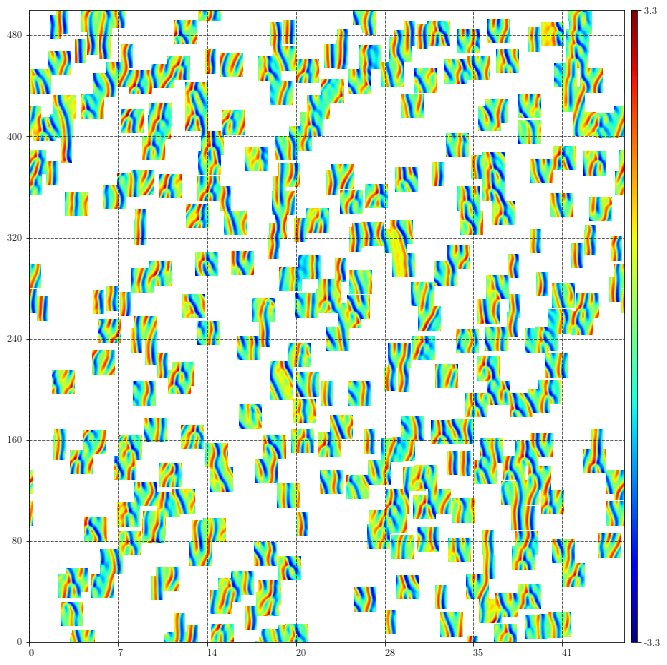

0.40630345090606507


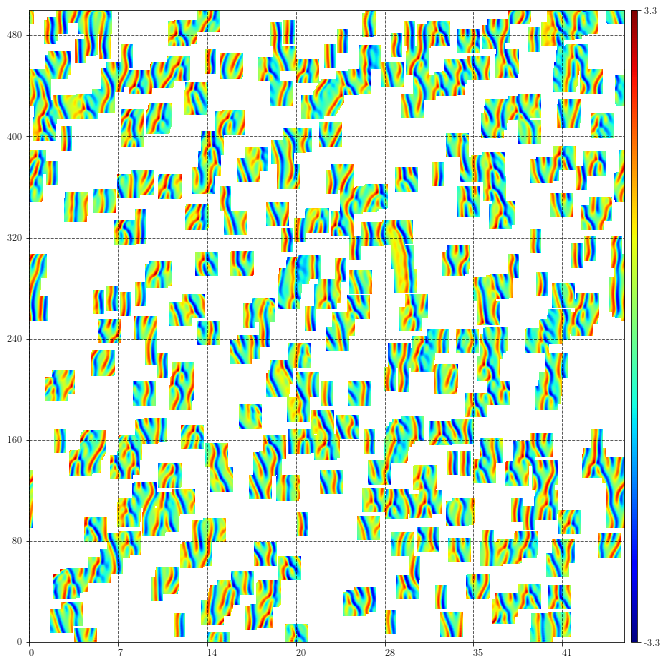

0.4299013036242604


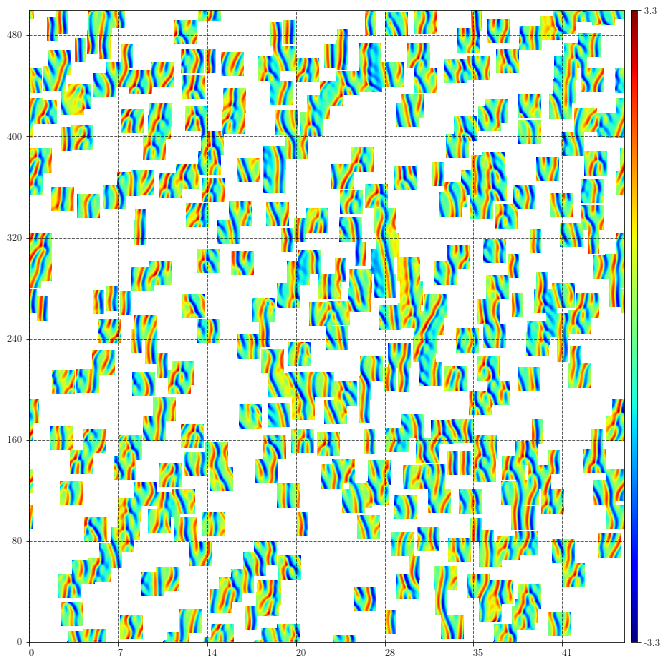

0.47921482063609466


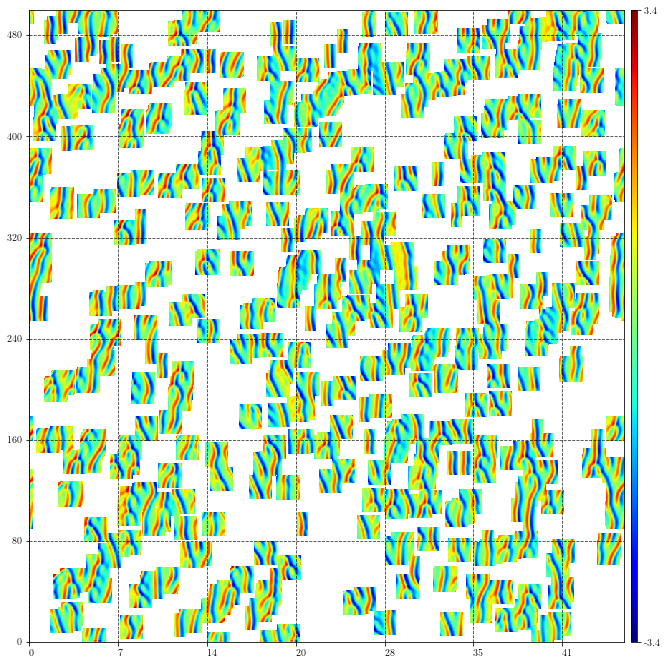

In [65]:
print(mask_strict_density.astype(bool).sum()/mask_strict_density.size)
large_patch.mask(mask_strict_density).plot()
print(mask_strict_unmasked_density.astype(bool).sum()/mask_strict_unmasked_density.size)
large_patch.mask(mask_strict_unmasked_density).plot()
print(mask_strict_meanflow.astype(bool).sum()/mask_strict_meanflow.size)
large_patch.mask(mask_strict_meanflow).plot()
print(mask_strict_unmasked_meanflow.astype(bool).sum()/mask_strict_unmasked_meanflow.size)
large_patch.mask(mask_strict_unmasked_meanflow).plot()

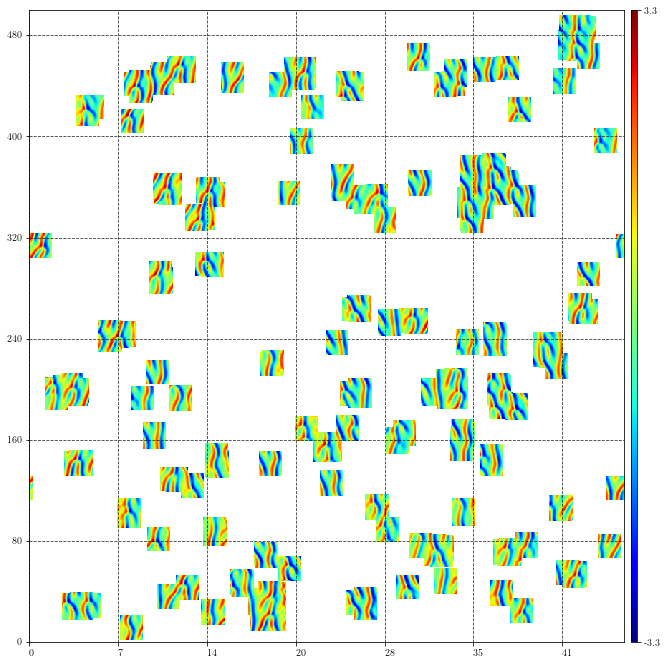

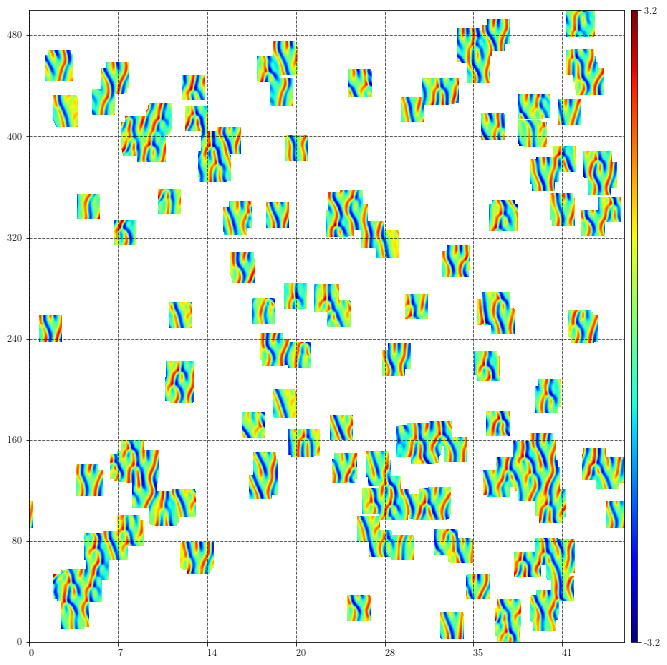

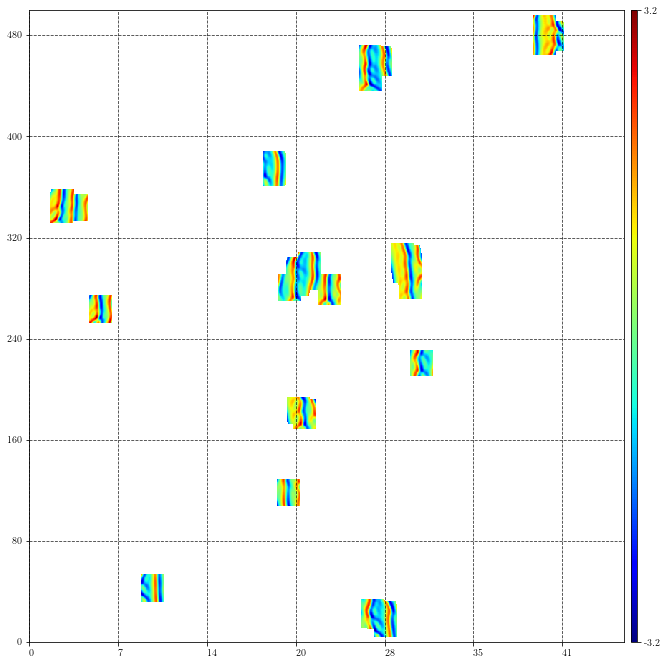

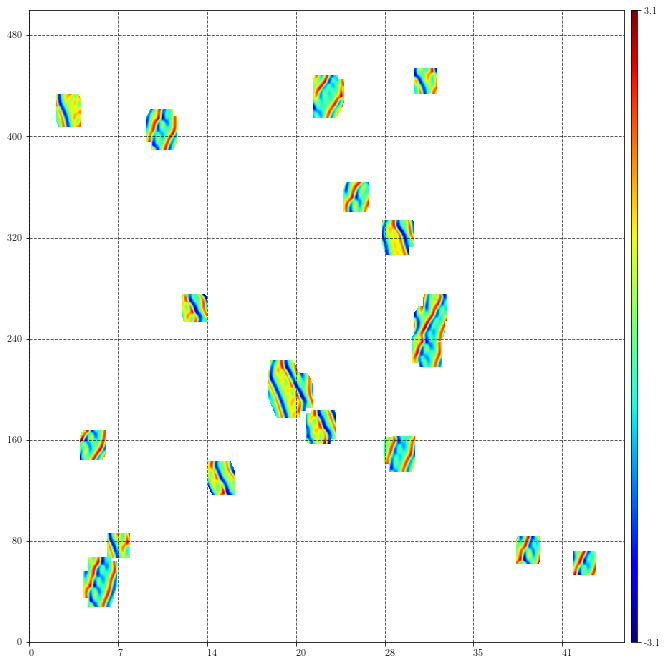

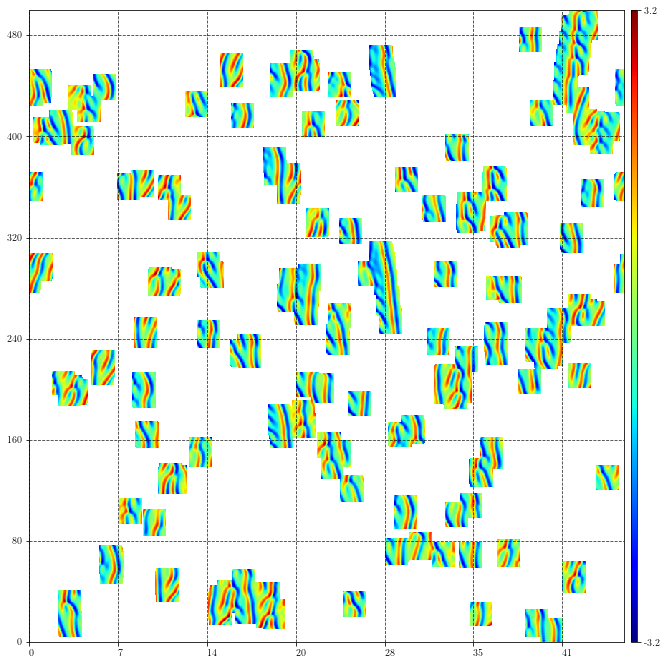

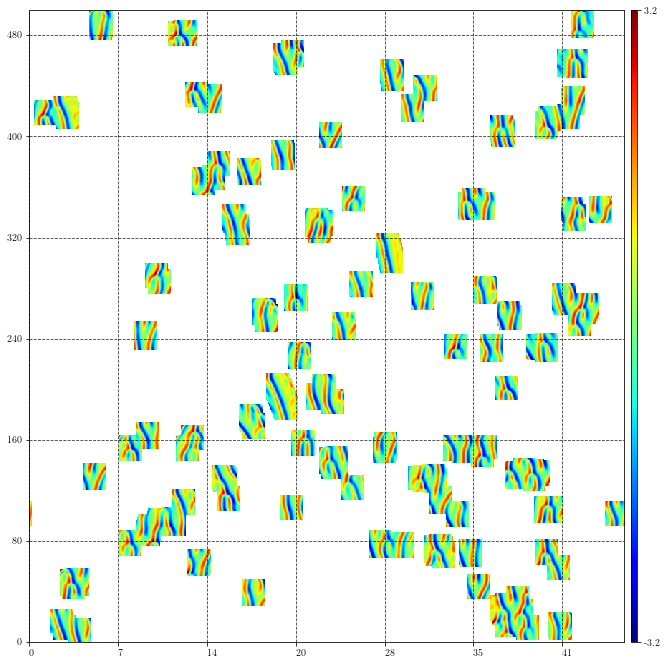

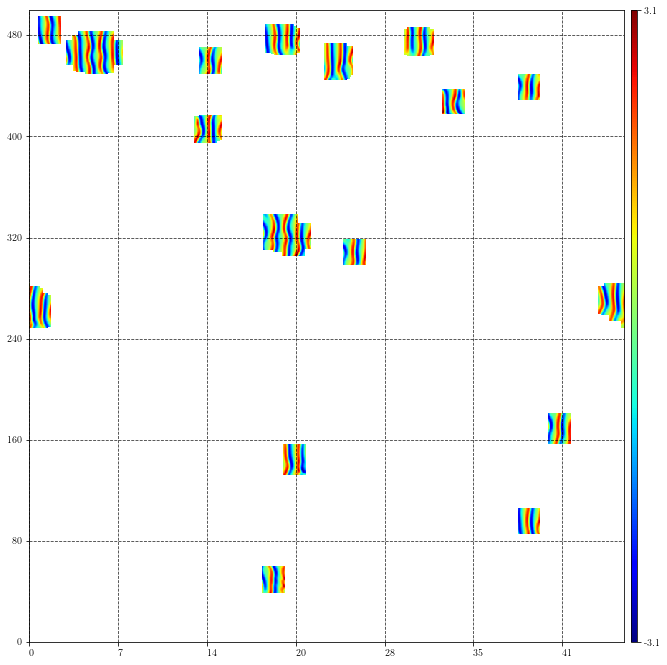

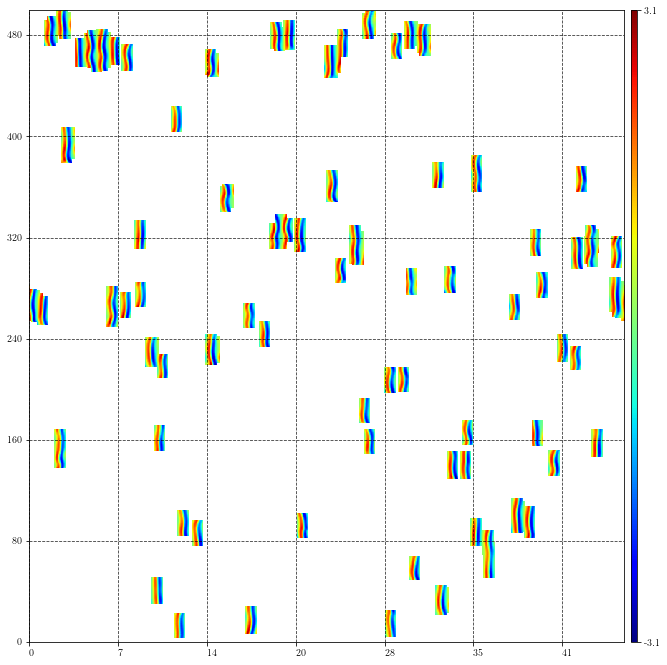

In [16]:
covers = read_h5('strict_large_patch_covering.h5')
# covers = [x for y in covers for x in y]

def vifunc_(name, obj):
    if isinstance(obj, h5py.Dataset):
        names.append(int(name))
    
with h5py.File('strict_large_patch_covering.h5', 'r') as file:
    fnames = []
    for each_family in file:
        names = []
        file[each_family].visititems(vifunc_)
        fnames.append(names)

windows_total = windows+windows_fd
detected_windows = [np.array(window_family)[sorted(x)] for x, window_family in zip(fnames, windows_total)]

for family_covers in covers:
    fmask = None
    for orbit_mask in family_covers:
        if fmask is None:
            fmask = orbit_mask.state
        else:
            fmask = np.logical_or(fmask.astype(bool), orbit_mask.state.astype(bool))
    large_patch.mask(fmask).plot()

In [ ]:
print('The mean flow correction L2 difference covered %.2f percent of space-time' %
 (100*mask_meanflow.astype(bool).sum()/mask_meanflow.size))

In [ ]:
large_patch.plot()

In [ ]:
large_patch.mask(mask_meanflow, invert=True).plot()

In [ ]:
large_patch.mask(mask_meanflow, invert=False).plot()

# Less strict simulations
The following is just the same code as above but with different strictness parameter. 

In [86]:
# Get the less strict thresholds
strictness = 1
critical_l2_diff_values = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values.append(file['defect/l2_difference'][...][strictness])
    critical_l2_diff_values.append(file['drifter/l2_difference'][...][strictness])
    critical_l2_diff_values.append(file['large_defect/l2_difference'][...][strictness])
    critical_l2_diff_values.append(file['wiggle/l2_difference'][...][strictness])

critical_l2_diff_values_fd = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values_fd.append(file['defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['drifter/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['large_defect/l2_difference_fundamental_domain'][...][strictness])
    critical_l2_diff_values_fd.append(file['wiggle/l2_difference_fundamental_domain'][...][strictness])

windows = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=False)) for x in minimal_orbits]
windows_fd = [tuple(x.group_orbit(rolls=(12, 12), fundamental_domain=True)) for x in minimal_orbits]
windows_total = [x for y in windows+windows_fd for x in y]

# Windows don't change but cvalues do. 
cvalues = [len(windows[i])*[critical_l2_diff_values[i]/windows[i][0].size] for i in range(len(windows))]
cvalues_fd = [len(windows_fd[i])*[critical_l2_diff_values_fd[i]/windows_fd[i][0].size] for i in range(len(windows_fd))]
cvalues_density = [x for y in cvalues+cvalues_fd for x in y]

cvalues_total = [windows_total[i].size * cvalues_density[i] for i in range(len(windows_total))]
window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)    

Subset of total orbits which were detected (from previous exhaustive calculations)

In [87]:
with h5py.File('most_frequent_from_1212_group_orbit.h5', 'r') as file:
    oind = file['most_frequent_orbit_indices'][...] 

cvalues_density_subset = [x for i, x in enumerate(cvalues_density) if i in oind]

cvalues_subset = [x for i, x in enumerate(cvalues_total) if i in oind]

windows_subset = [x for i, x in enumerate(windows_total) if i in oind]

window_keys_subset = [x for i, x in enumerate(window_keys) if i in oind]

# Less strict $L_2$ density

### Masked $L_2$ density difference

In [88]:
t0l0=time.time_ns()/10**9
fill_result_tuple = fill(large_patch, cvalues_density_subset, windows_subset,
                         scoring_function=masked_l2_difference_density,
                         base_orbit_periodicity=(False, True),
                         verbose=True, subtract_field=True)
filled_lax_density, mask_lax_density, weights_lax_density = fill_result_tuple
t1l0=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l0-t0l0)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots
#############################################################################################Large patch filling took 20.99 minutes to complete


### Unmasked $L_2$ density difference

In [89]:
t0l1=time.time_ns()/10**9
fill_result_tuple = fill(large_patch, cvalues_density_subset, windows_subset,
                                                    scoring_function=l2_difference_density,
                                                    base_orbit_periodicity=(False, True),
                                                    verbose=True, subtract_field=False)
filled_lax_unmasked_density, mask_lax_unmasked_density, weights_lax_unmasked_density = fill_result_tuple
t1l1=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l1-t0l1)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots
#############################################################################################Large patch filling took 11.35 minutes to complete


# Lax threshold with mean flow correction

In [90]:
# Less strict mean value thresholds
strictness = 1
critical_l2_diff_values_mean_flow = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values_mean_flow.append(file['defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values_mean_flow.append(file['drifter/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values_mean_flow.append(file['large_defect/l2_difference_mean_flow_correction'][...][strictness])
    critical_l2_diff_values_mean_flow.append(file['wiggle/l2_difference_mean_flow_correction'][...][strictness])

critical_l2_diff_values_mean_flow_fd = []
with h5py.File('./local/critical_values.h5', 'r') as file:
    critical_l2_diff_values_mean_flow_fd.append(file['defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_mean_flow_fd.append(file['drifter/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_mean_flow_fd.append(file['large_defect/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])
    critical_l2_diff_values_mean_flow_fd.append(file['wiggle/l2_difference_mean_flow_correction_fundamental_domain'][...][strictness])

# Windows don't change but cvalues do. 
cvalues_mean_flow = [len(windows[i])*[critical_l2_diff_values_mean_flow[i]/windows[i][0].size]
                     for i in range(len(windows))]
cvalues_mean_flow_fd = [len(windows_fd[i])*[critical_l2_diff_values_mean_flow_fd[i]/windows_fd[i][0].size]
                        for i in range(len(windows_fd))]
cvalues_mean_flow_density = [x for y in cvalues_mean_flow+cvalues_mean_flow_fd
                             for x in y]
cvalues_mean_flow_total = [windows_total[i].size * cvalues_mean_flow_density[i] for i in range(len(windows_total))]

window_keys = np.repeat(np.tile(np.array([[1,2,3,4]]),2), 18)    

In [91]:
cvalues_mean_flow_density_subset = [x for i, x in enumerate(cvalues_mean_flow_density) if i in oind]

cvalues_mean_flow_subset = [x for i, x in enumerate(cvalues_mean_flow_total) if i in oind]

windows_subset = [x for i, x in enumerate(windows_total) if i in oind]

window_keys_subset = [x for i, x in enumerate(window_keys) if i in oind]

### Masked $L_2$ density difference, mean flow correction

In [92]:
t0l2=time.time_ns()/10**9
fill_result_tuple = fill(large_patch, cvalues_mean_flow_density_subset, windows_subset,
                         scoring_function=masked_l2_difference_mean_flow_correction_density,
                         base_orbit_periodicity=(False, True),
                         verbose=True, subtract_field=True)
filled_lax_meanflow, mask_lax_meanflow, weights_lax_meanflow = fill_result_tuple
t1l2=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l2-t0l2)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.


#############################################################################################Large patch filling took 30.97 minutes to complete


### Unmasked $L_2$ density difference, mean flow correction

In [93]:
t0l3=time.time_ns()/10**9
fill_result_tuple = fill(large_patch, cvalues_mean_flow_density_subset, windows_subset,
                         scoring_function=l2_difference_mean_flow_correction_density,
                         base_orbit_periodicity=(False, True),
                         verbose=True, subtract_field=False)
filled_lax_unmasked_meanflow, mask_lax_unmasked_meanflow, weights_lax_unmasked_meanflow = fill_result_tuple
t1l3=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1l3-t0l3)/60.))

Scanning interior pivots
######################################################################################Scanning exterior pivots
#############################################################################################Large patch filling took 18.27 minutes to complete


In [103]:
mask_lax_unmasked_meanflow

array([[83., 83., 83., ..., 83., 83., 83.],
       [83., 83., 83., ..., 83., 83., 83.],
       [83., 83., 83., ..., 83., 83., 83.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
print('The L2 difference density filling covered %.2f percent of space-time' %
 (100*mask_lax_density.astype(bool).sum()/mask_meanflow.size))

In [95]:
lax_large_patch_covering = read_h5('lax_large_patch_covering.h5')

In [111]:
conversion_dict = dict(zip(range(1, len(window_keys_subset)+1), window_keys_subset))
conversion_dict[0] = 0
value = 1
msktmp = mask_lax_meanflow.copy()

weights_meanflow_converted = {1:0, 2:0, 3:0, 4:0}
for k,v in weights_lax_unmasked_meanflow.items():
    msktmp[msktmp!=v] == 0 
    weights_meanflow_converted[conversion_dict[k]]+=v

(RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, -3.399]}),
 RelativeOrbitKS({"shape": [32, 32], "basis": "field", "parameters": [14.301, 13.038, 3.399]}),
 RelativeOrbitKS({"shape": [32,

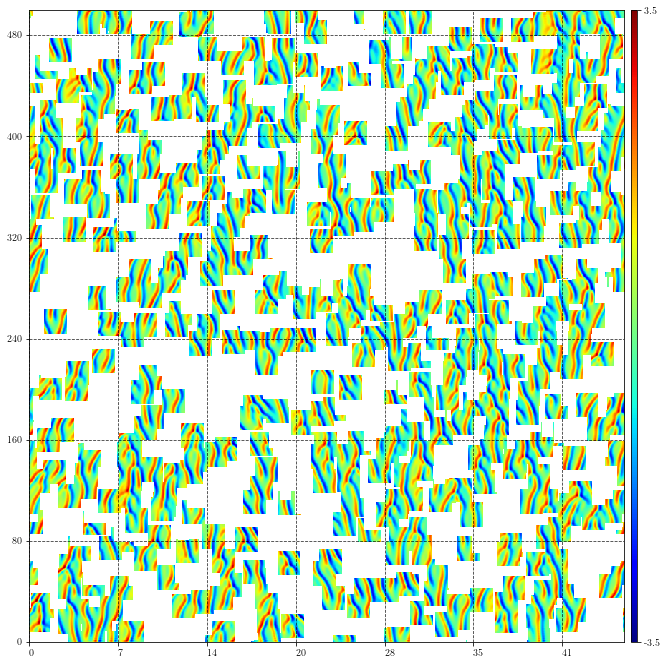

In [118]:
converted = mask_lax_meanflow.copy()
for k, v in conversion_dict.items():
    converted[converted==k] = v
converted[(converted==2.) | (converted==4.)] = 0 
large_patch.mask(converted).plot()

In [128]:
test = np.pad(np.eye(3), ((1,1),(2,2)), mode=('wrap', 'constant'))

ValueError: mode '('wrap', 'constant')' is not supported

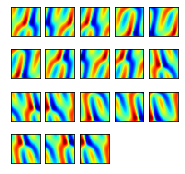

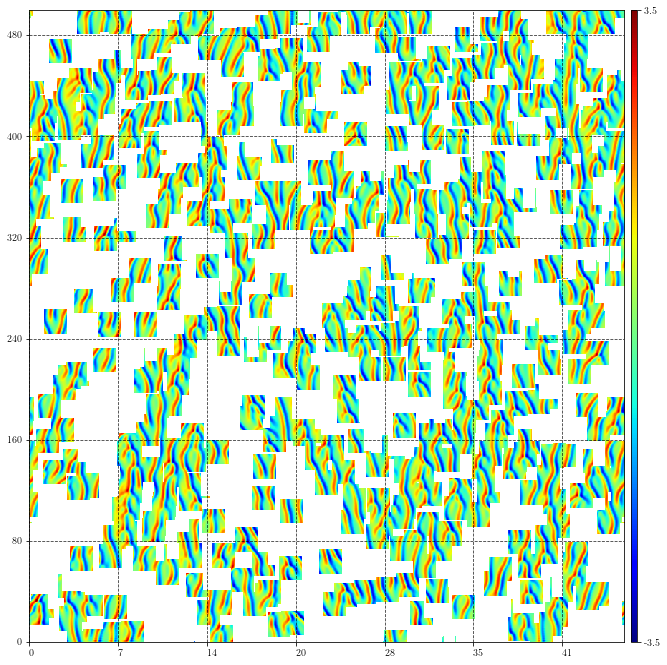

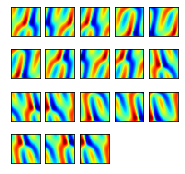

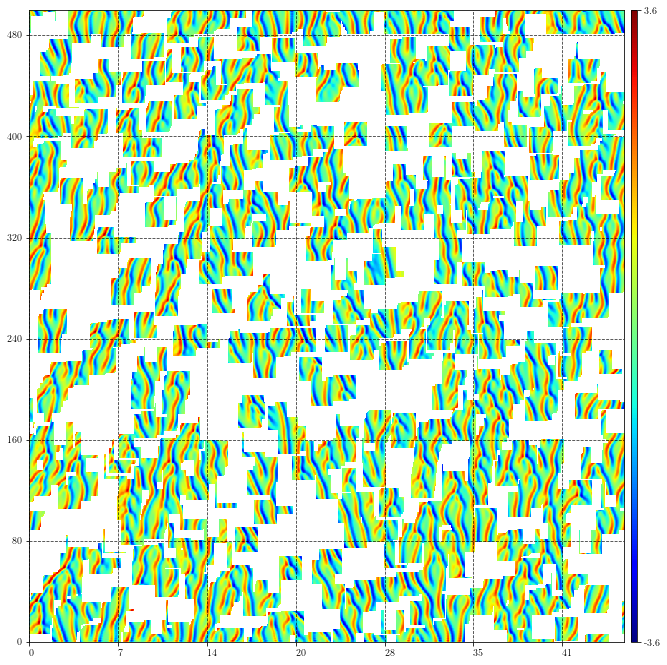

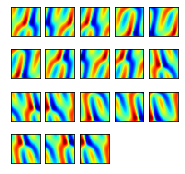

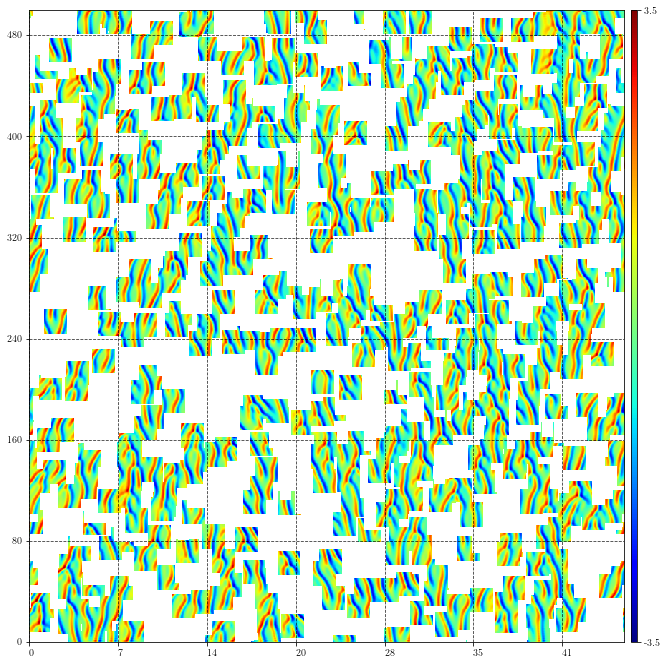

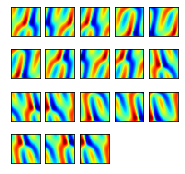

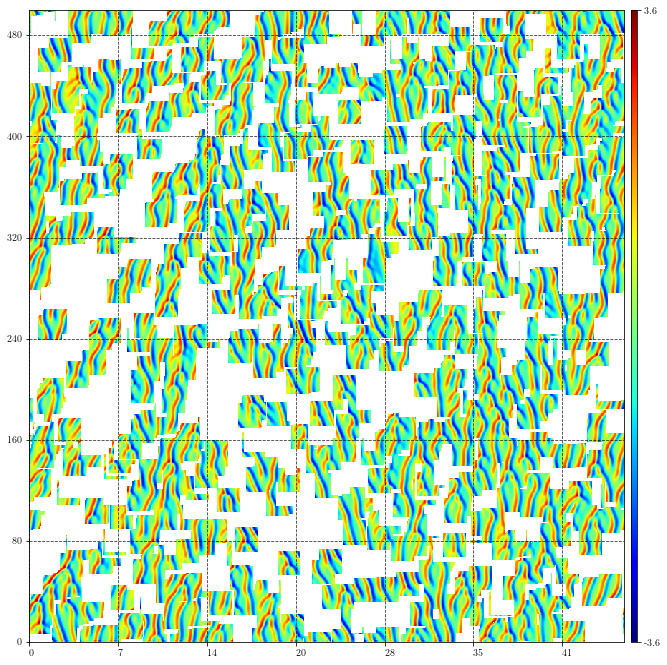

In [127]:
for function_masks in [mask_lax_density,mask_lax_unmasked_density,
                       mask_lax_meanflow,mask_lax_unmasked_meanflow]:
    converted = function_masks.copy()
    for k, v in conversion_dict.items():
        converted[converted==k] = v
    converted[(converted==2.) | (converted==4.)] = 0 
#     converted[(converted!=1.)] = 0 
    fig = plt.figure(figsize=(3,3))
    grid = gridspec.GridSpec(4, 5)
    for gs, orbit in zip(grid, windows[0]):
        ax = plt.subplot(gs)
        ax.imshow(orbit.state, cmap='jet')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    _ = plt.show()
    _ = plt.close()
    large_patch.mask(converted).plot()


masked 0.6952734952847633


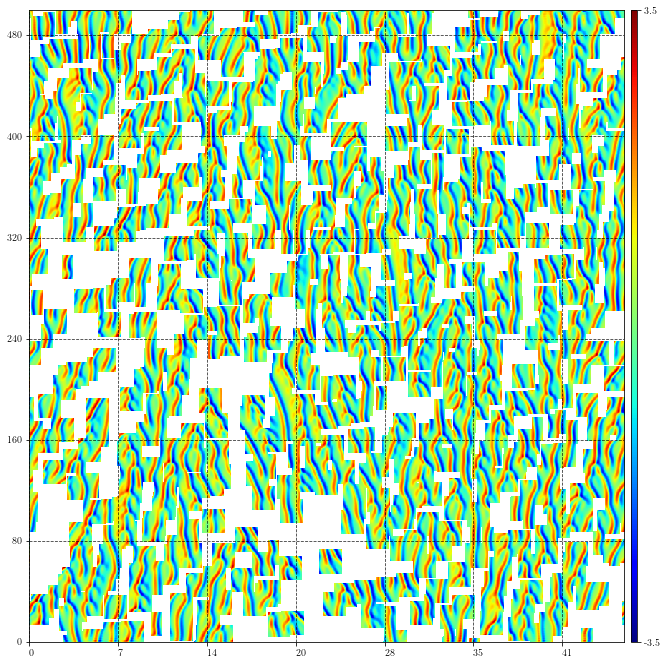

unmasked 0.7548394739275148


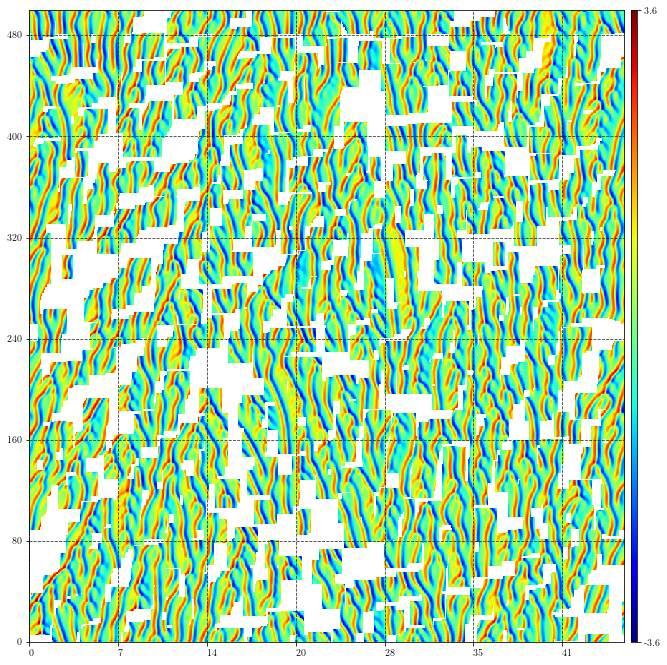

masked mean flow 0.7004466762204142


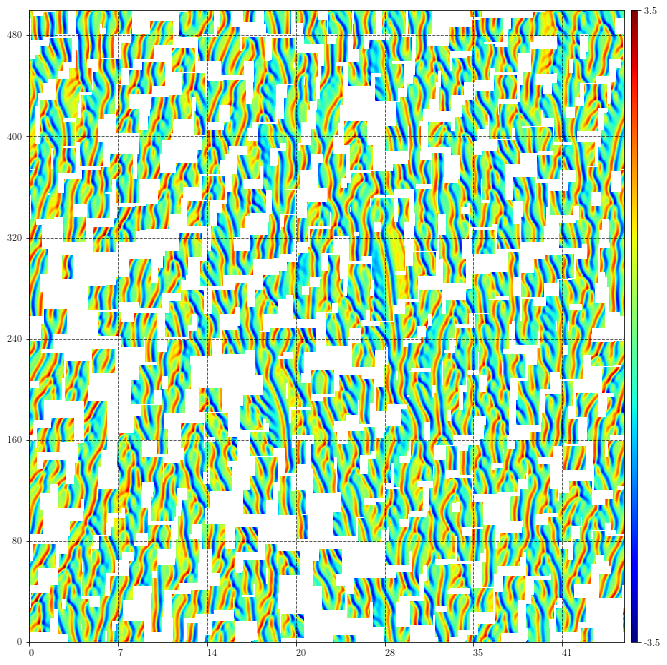

umasked mean flow 0.7779533792529586


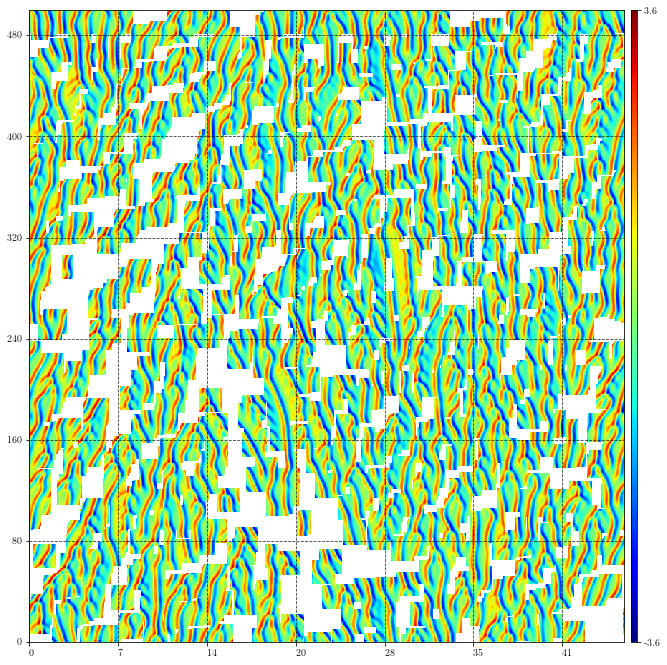

In [121]:
print('masked', mask_lax_density.astype(bool).sum()/mask_lax_density.size)
large_patch.mask(mask_lax_density).plot()
print('unmasked', mask_lax_unmasked_density.astype(bool).sum()/mask_lax_unmasked_density.size)
large_patch.mask(mask_lax_unmasked_density).plot()
print('masked mean flow', mask_lax_meanflow.astype(bool).sum()/mask_lax_meanflow.size)
large_patch.mask(mask_lax_meanflow).plot()
print('umasked mean flow', mask_lax_unmasked_meanflow.astype(bool).sum()/mask_lax_unmasked_meanflow.size)
large_patch.mask(mask_lax_unmasked_meanflow).plot()

# Heterogeneous discretizations

In [66]:
base_orbits = [y for y in  read_h5('./local/small_patches.h5')]

t0fam=time.time_ns()/10**9
mean_flow_masks = []
mean_flow_weights = []
for base in base_orbits:
    print('#', end='')
    _, m, w = fill(base, cvalues_mean_flow_total, windows_total,
                    scoring_function=l2_difference_mean_flow_correction,
                    base_orbit_periodicity=(False, False),
                    verbose=False, subtract_field=False)
    mean_flow_masks.append(m)
    mean_flow_weights.append(w)
t1fam=time.time_ns()/10**9
print('Large patch filling took {:.2f} minutes to complete'.format((t1fam-t0fam)/60.))

Export and save the data because it took so long to complete. Commented out to prevent accidental overwrites. 

In [ ]:
# with h5py.File('small_patch_l2_difference_mean_flow_masks.h5', 'w') as file:
#     for i, msk in enumerate(mean_flow_masks):
#         file.create_dataset(str(i), data=msk)

# with h5py.File('small_patch_l2_difference_mean_flow_weights.h5', 'w') as file:
#     file.create_dataset('weights', data=weights_to_save)

# with h5py.File('most_frequent_from_1212_group_orbit.h5', 'w') as file:
#     file.create_dataset('most_frequent_orbit_indices', data=most_frequent_orbits)

In [152]:
wght_array = []
for i, wdict in enumerate(mean_flow_weights):
    wght_array.append(np.array(list(wdict.values())))

weights_to_save = np.concatenate([x.reshape(1, -1) for x in wght_array])
avg_freq = weights_to_save.mean(axis=0)

most_frequent_orbits = np.where(avg_freq > 0.001)[0]
for x in np.array(windows_total)[np.where(avg_freq > 0.001)[0]]:
    x.plot()

# Mistake in previous calculation

I ran the last (very long) simulation under the premise that the idea of subtracting the field and using a density can lead to non-sensible results like L-shaped shadowing regions simply as a numerical artifact. Therefore, I used the L2 difference with mean flow correction as a metric. However, I forgot to account for the fact that windows that are partially out of bounds are allowed, and so the absolute/total value threshold does not make sense, even in the case where the base field is left untouched. Therefore the results are much much less strict than they should be. This is not entirely without merit however; because it is indeed less strict, the fact that certain orbits appeared with such low frequency even in this case means that the number of orbits can be reduced for future computations, which will proceed now using the L2 density mean flow correction without subtracting the field.

In [100]:
plt.plot(weights_to_save.mean(axis=0))

NameError: name 'weights_to_save' is not defined

<Figure size 864x864 with 0 Axes>

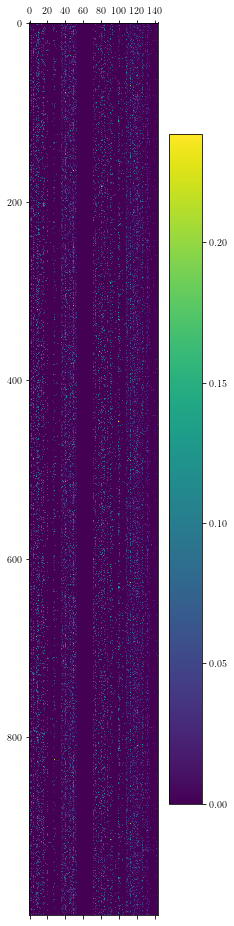

In [91]:
plt.figure(figsize=(12,12))
plt.matshow(weights_to_save)
plt.colorbar()
plt.show()

In [ ]:
converted = mask_density.copy()
weights_meanflow_converted = {1:0, 2:0, 3:0, 4:0}
for k, v in conversion_dict.items():
    converted[converted==k] = v
    if k != 0.:
        weights_meanflow_converted[conversion_dict[k]] += weights_meanflow[k]

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(mask_meanflow.astype(bool).astype(float))
plt.colorbar()
plt.show()

In [ ]:
lccmasks = []
def vifunc_(name, obj):
    if type(obj) == h5py.Dataset:
        lccmasks.append(obj[...])

with h5py.File('./local/large_patch_complete_covering.h5', 'r') as file:
    file.visititems(vifunc_)
    
mask_union = lccmasks[0]
for m in lccmasks[1:]:
    mask_union = np.logical_or(mask_union, m)